In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from utils import seed_everything, load_config
from models import EEGEncoder, AudioEncoder, Projection
from dataset import get_clip_loader
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = load_config("./configs/CLIP_trainer.yaml")
eeg_data_config = config["eeg_data"]
audio_data_config = config['audio_data']
eeg_config = config["EEGNet"]
audio_config = config['AudioNet']
train_config = config["train"]
seed_everything(42) #42

In [3]:
class add_proj_enc(nn.Module):
    def __init__(self, encoder, proj_enc):
        super(add_proj_enc,self).__init__()
        self.encoder = encoder
        self.proj_enc = proj_enc

    def forward(self,inputs):
        x = self.encoder(inputs)
        x = self.proj_enc(x)
        
        return x

In [5]:
csv_dir = "./data/split_wav_csv"
eeg_list = sorted(glob("./data/split_eeg/exp_0/subj0_*.csv")) ## exp_anything? exp_specifiy?

# csv_dir = "./data/split_wav_csv"
# eeg_list = sorted(glob("./data/split_eeg/*/*.csv"))
clip_loader = get_clip_loader(csv_dir, eeg_list, audio_data_config, 16)

In [21]:
trial = 0

csv_dir = "./data/split_wav_csv"
total_eeg = sorted(glob('./data/split_eeg/exp_0/subj0_*.csv'),key=lambda x:int(x.split('/')[4].split('_')[1][1:]))

idx = trial*58
eeg_valid_list = total_eeg[idx:idx+58]
del total_eeg[idx:idx+58]

clip_loader = get_clip_loader(csv_dir, eeg_valid_list, audio_data_config, 16)

In [22]:
audio_input_shape = clip_loader.dataset.get_audio_input_shape()
audio_encoder = AudioEncoder(audio_input_shape, audio_config["n_layer"], audio_config["channels"])
dim = (audio_input_shape[1] // (2**audio_encoder.n_layer)) * (audio_input_shape[2] // (2**audio_encoder.n_layer)) * audio_encoder.channels[-1]
audio_encoder = add_proj_enc(audio_encoder,Projection(dim, audio_config['hidden_dim'], audio_config['latent_dim']))
audio_encoder.load_state_dict(torch.load(f"ckpt_temp/LOOCV/noproj_clip/audio_Trial_{trial}.ckpt"))

eeg_encoder = EEGEncoder(eeg_config)
eeg_encoder = add_proj_enc(eeg_encoder,Projection(16*40, eeg_config['hidden_dim'], eeg_config['latent_dim']))
eeg_encoder.load_state_dict(torch.load(f"ckpt_temp/LOOCV/noproj_clip/eeg_Trial_{trial}.ckpt"))

audio_encoder.eval()
eeg_encoder.eval()

add_proj_enc(
  (encoder): EEGEncoder(
    (shallow_net): ShallowEncoderNet(
      (temporal_conv): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
      (spatial_conv): Conv2d(40, 40, kernel_size=(60, 1), stride=(1, 1))
      (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0)
      (avgpool): AvgPool2d(kernel_size=(1, 25), stride=(1, 5), padding=0)
      (dr): Dropout(p=0.2, inplace=False)
      (enhance_conv): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
    )
    (trns_enc): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderBlock(
          (multi_head_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
          )
          (feed_foward): Sequential(
            (0): Linear(in_features=40, out_features=160, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=F

In [23]:
eeg, mel = next(iter(clip_loader))

eeg = eeg.float()
mel = mel.float()

In [24]:
audio_vector = audio_encoder(mel)
eeg_vector = eeg_encoder(eeg)
norm_audio = F.normalize(audio_vector, p=2., dim=1)
norm_eeg = F.normalize(eeg_vector, p=2., dim=1)

logits = torch.matmul(norm_audio, norm_eeg.transpose(1, 0))
labels = torch.arange(logits.shape[0])
loss_audio = F.cross_entropy(logits, labels)
loss_eeg = F.cross_entropy(logits.transpose(1, 0), labels)
loss = (loss_audio + loss_eeg) / 2

print(loss.item())

2.7985904216766357


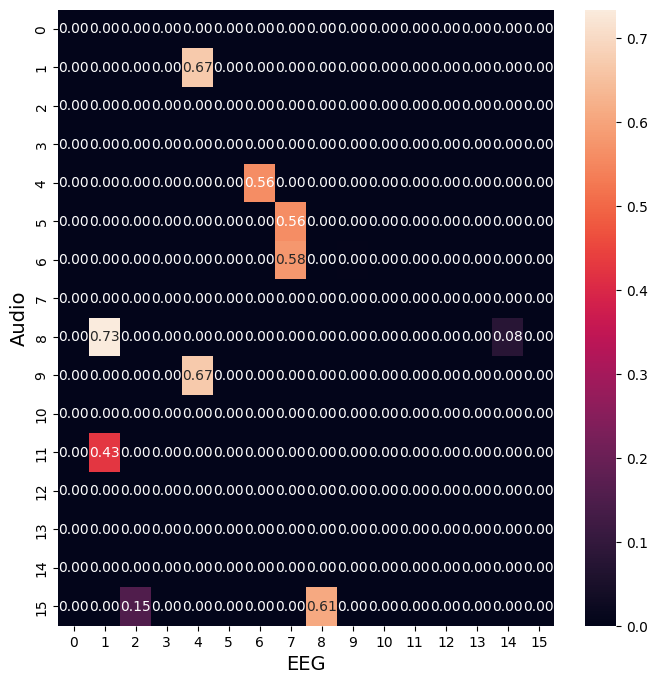

In [25]:
plt.figure(figsize=(8,8))
logits = logits.detach().numpy()
sns.heatmap(logits, annot=True, fmt=".2f")
plt.ylabel('Audio', fontsize=14)
plt.xlabel('EEG', fontsize=14)
plt.savefig("./matrix.png")

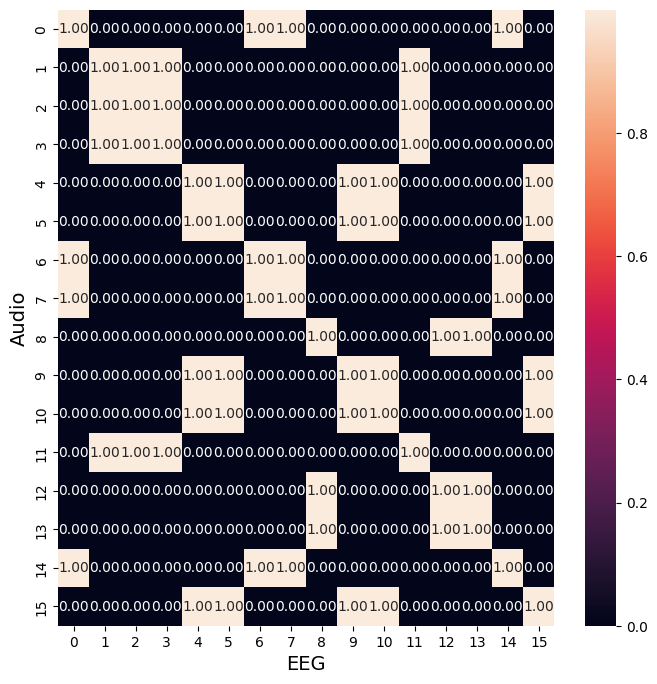

In [9]:
plt.figure(figsize=(8,8))
logits = logits.detach().numpy()
sns.heatmap(logits, annot=True, fmt=".2f")
plt.ylabel('Audio', fontsize=14)
plt.xlabel('EEG', fontsize=14)
plt.savefig("./matrix.png")

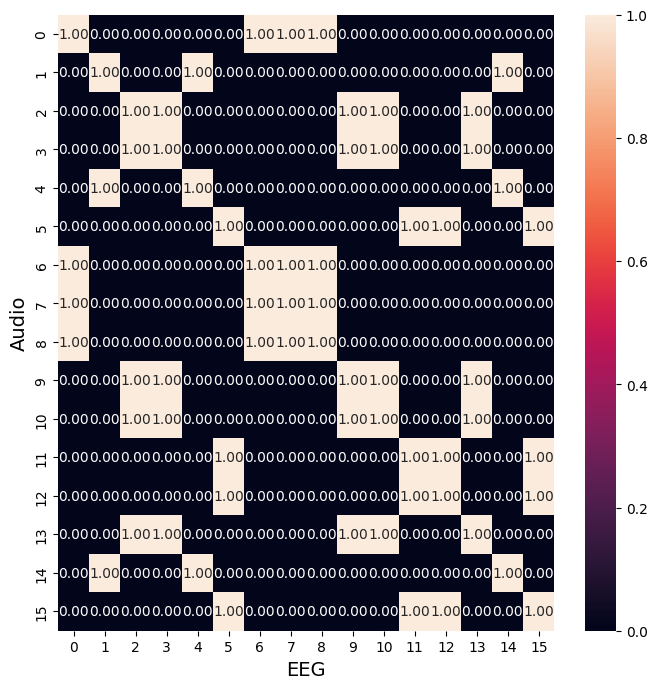

In [21]:
plt.figure(figsize=(8,8))
logits = logits.detach().numpy()
sns.heatmap(logits, annot=True, fmt=".2f")
plt.ylabel('Audio', fontsize=14)
plt.xlabel('EEG', fontsize=14)
plt.savefig("./matrix.png")